In [39]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
import lightgbm as lgb
import _pickle as pickle
from pathlib import Path

In [46]:
orig_train_df = pd.read_csv(str('train.csv'))
orig_test_df = pd.read_csv(str('test.csv'))
print(orig_train_df.columns)
display(orig_train_df)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [259]:
class CategoricalConverter:
    def __init__(self, to_dummy=False):
        self.forward_dict = None
        
    @property
    def backward_dict(self):
        if self.forward_dict is None:
            return None
        return dict(zip(self.forward_dict.values(), self.forward_dict.keys()))
    
    def forward(self, x):
        assert x.dtype.kind in ('O', 'i')
        x = x.fillna('NA')
        ux = np.unique(x)
        self.forward_dict = {'NA': -1} 
        self.forward_dict.update(
            dict(zip(ux, np.arange(len(ux))))
        )
        
        return x.replace(self.forward_dict)
    
    def backward(self, x):
        return x.replace(self.backward_dict)
    
class FloatConverter:
    def __init__(self, log=False, fillna=None):
        self.log = log
        self.fillna = fillna
    
    def apply_fillna(self, x):
        fillna_method = self.fillna
        if isinstance(fillna_method, str):
            value = getattr(x, fillna_method)()
        else:
            value = fillna_method
        return x.fillna(value)
        
    def forward(self, x):
        y = x.astype(np.float32)
        if self.log:
            y = np.log(y + 1)
        if self.fillna is not None:
            y = self.apply_fillna(y)
        return y
    
    def backward(self, x):
        if self.log:
            x = np.exp(x)
        return x
    
class DummyConverter:
    def __init__(self):
        pass
        
    def forward(self, xs):
        ys = pd.get_dummies(xs)
        return ys
    
    def backward(self, x):
        raise NotImplementedError()

    
    
CategoricalConverter().forward(orig_train_df['MiscFeature'])

0       1
1       1
2       1
3       1
4       1
       ..
1455    1
1456    1
1457    3
1458    1
1459    1
Name: MiscFeature, Length: 1460, dtype: int64

In [329]:
from sklearn.model_selection import KFold, train_test_split
indices_file = Path('indices.pickle')
indices = []

KFOLD = 5

if indices_file.exists():
    with open(indices_file, 'rb') as fp:
        indices = pickle.load(fp)
else:
    inds = np.arange(len(orig_train_df))
    kfold = KFold(KFOLD)
    for train_indices, test_indices in kfold.split(inds):
        train_indices, valid_indices = train_test_split(train_indices, train_size=0.8)
        indices.append({
            'train': train_indices,
            'valid': valid_indices,
            'test': test_indices,
        })

In [331]:
converters = {}
def get_dataset(fold_index, no_valid = False):
    fold_indices = indices[fold_index]
    train_indices = fold_indices['train']
    valid_indices = fold_indices['valid']
    testg_indices = fold_indices['test']
    if no_valid:
        test_df = orig_test_df
        valid_df = orig_train_df.iloc[test_indices]
        train_df = orig_train_df.iloc[np.concatenate([train_indices, valid_indices])]
    else:
        train_df = orig_train_df.iloc[train_indices]
        valid_df = orig_train_df.iloc[valid_indices]
        test_df = orig_train_df.iloc[test_indices]
        
    return train_df, valid_df, test_df

def preprocess_xs(xs_df, converters=None, fillna=None):
    if converters is None:
        converters = {}
        for col, dtype in xs_df.dtypes.items():
            if dtype.kind == 'O':
                conv = CategoricalConverter()
            else:
                conv = FloatConverter(fillna=fillna)
            converters[col] = conv

    for col in xs_df.columns:
        xs_df.loc[:, col] = converters[col].forward(xs_df[col])
    
    return xs_df, converters
        
def preprocess(xs_df, ys_df, converters=None, y_log=True, **kwargs):
    xs_df, converters = preprocess_xs(xs_df, converters=converters, **kwargs)
    if ys_df is not None:
        conv = FloatConverter(log=y_log)
        converters['SalePrice'] = conv
        ys_df = conv.forward(ys_df)
    return xs_df, ys_df, converters

def get_data(df, no_y=False, **kwargs):
    if no_y:
        df, _ = preprocess(df, None, **kwargs)
        return df
    else:
        xs_df =  df.drop(columns=['SalePrice'])
        ys_df = df['SalePrice']
        return preprocess(xs_df, ys_df, **kwargs)


In [332]:
no_valid = False
train_df, valid_df, test_df = get_dataset(0, no_valid=no_valid)
if no_valid:
    train_df = get_data(train_df)
    valid_df = get_data(valid_df)
    test_xs_df = get_data(test_df, no_y=True)
else:
    train_xs_df, train_ys_df, converters = get_data(train_df, fillna='median')
    valid_xs_df, valid_ys_df, _ = get_data(valid_df, converters=converters)
    test_xs_df, test_ys_df, _ = get_data(test_df, converters=converters)

# Baseline (LightGBM)

In [75]:
model_params = dict(
    n_estimators=2000,
    learning_rate=1e-2,
    verbosity=-1,
    objective='fair',
    n_jobs=16,
    max_depth=8,
    lambda_l1=1e-1,
    lambda_l2=1e1,
)
lgb.LGBMModel(**model_params)

LGBMModel(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
          importance_type='split', lambda_l1=0.1, lambda_l2=10.0,
          learning_rate=0.01, max_depth=8, min_child_samples=20,
          min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
          n_jobs=16, num_leaves=31, objective='fair', random_state=None,
          reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
          subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [78]:
models = []
for i in trange(KFOLD):
    train_df, valid_df, test_df = get_dataset(i, no_valid=no_valid)
    train_xs_df, train_ys_df, converters = get_data(train_df)
    valid_xs_df, valid_ys_df, _ = get_data(valid_df, converters=converters)
    test_xs_df, test_ys_df, _ = get_data(test_df, converters=converters)
        
    model = lgb.LGBMModel(**model_params)
    model.fit(
        train_xs_df, train_ys_df,
        eval_set=(valid_xs_df, valid_ys_df),
        verbose=False
    )
    models.append(model)

In [94]:
# Evaluation models
gbdt_metrics = []
for key, model in enumerate(models):
    train_df, valid_df, test_df = get_dataset(i, no_valid=no_valid)
    train_xs_df, train_ys_df, _ = get_data(train_df, converters=converters)
    valid_xs_df, valid_ys_df, _ = get_data(valid_df, converters=converters)
    test_xs_df, test_ys_df, _ = get_data(test_df, converters=converters)
    
    data = [
        ('train', train_xs_df, train_ys_df),
        ('valid', valid_xs_df, valid_ys_df),
        ('test', test_xs_df, test_ys_df),
    ]
    
    ys_conv = converters['SalePrice']
    for name, xs_df, ys_df in data:
        ys_pred = ys_conv.backward(model.predict(xs_df))
        ys_truth = ys_conv.backward(ys_df.to_numpy())
        
        errors = np.abs(ys_pred - ys_truth)
        gbdt_metrics.extend([
            {
                'id': i,
                'fold': key,
                'error': error,
                'name': name,
                'truth': truth, 
                'pred': pred
            }
            for i, error, pred, truth in zip(xs_df['Id'], errors, ys_pred, ys_truth)
        ])
gbdt_metrics_df = pd.DataFrame(gbdt_metrics)

train


count      2990.000000
mean       8536.184204
std       15825.960202
min           7.769069
25%        1522.933782
50%        3744.048908
75%        9484.004253
max      343265.038974
Name: error, dtype: float64

valid


count       750.000000
mean      16046.309982
std       25487.385267
min          15.515455
25%        4054.779298
50%        9548.414848
75%       18940.595513
max      319816.294260
Name: error, dtype: float64

test


count       930.000000
mean      13028.965550
std       15801.409632
min           5.419089
25%        4036.365889
50%        8960.300927
75%       16697.865202
max      186222.937979
Name: error, dtype: float64

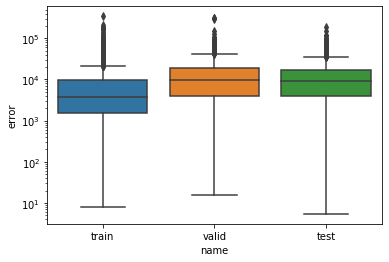

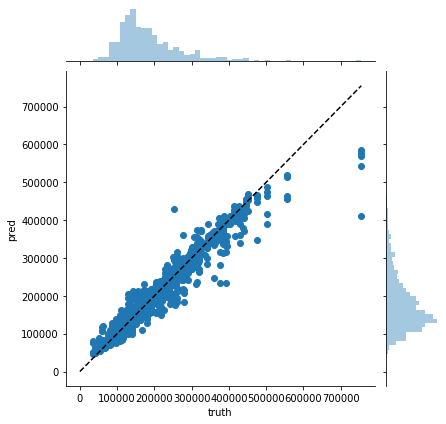

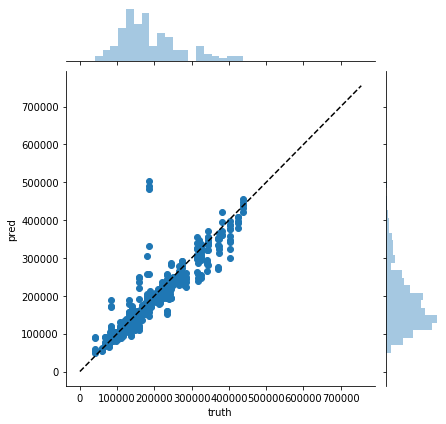

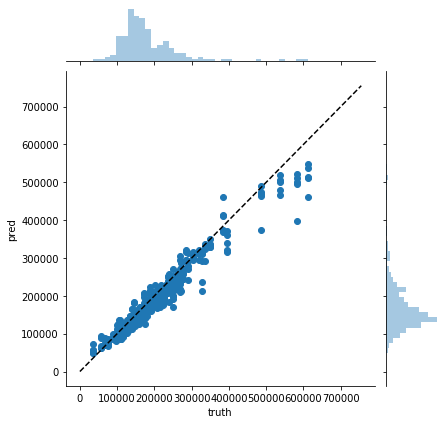

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sns.boxplot(
    data=gbdt_metrics_df,
    x='name',
    y='error',
    ax=ax,
)
ax.set_yscale('log')

max_price = gbdt_metrics_df['truth'].max()
for name in ['train', 'valid', 'test']:
    df = gbdt_metrics_df.query(f'name=="{name}"')
    grid = sns.jointplot(
        data=df,
        x='truth',
        y='pred',
    )
    grid.ax_joint.plot([0,max_price], [0,max_price], color='k', linestyle='--')
    print(name)
    display(df['error'].describe())

# Deep Learning

In [344]:
import tensorflow as tf
import numpy as np
from collections import defaultdict
from io import BytesIO
import imageio
from IPython.display import display_png, clear_output, Image

class DenseRegressor(tf.keras.Model):
    def __init__(self, units, activation=tf.nn.elu, **kwargs):
        super().__init__()
        self.dense_layers = []
        for dim in units[:-1]:
            self.layers.append(
                tf.keras.layers.Dense(dim, activation, **kwargs)
            )
        self.dense_layers.append(
            tf.keras.layers.Dense(units[-1], **kwargs)
        )
    def call(self, x):
        y = x
        for d in self.dense_layers:
            y = d(y)
        return y

class ResidualDense(tf.keras.Model):
    def __init__(self, units, use_bn=True, activation=tf.nn.elu, **kwargs):
        super().__init__()
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.d1 = tf.keras.layers.Dense(units, **kwargs)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.d2 = tf.keras.layers.Dense(units, **kwargs)
        self.activation = activation

    @tf.function
    def call(self, x, training=True):
        y = self.activation(self.d1(self.bn1(x, training=training), training=training))
        y = self.activation(self.d2(self.bn2(y, training=training), training=training))
        return y + x


class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, n_layers=40, n_dims=None, **kwargs):
        super().__init__()
        if n_dims is None:
            n_dims = output_dim
        self.d0 = tf.keras.layers.Dense(n_dims, activation=tf.nn.elu, **kwargs)
        self.dense_layers = [
            ResidualDense(n_dims, **kwargs) for i in range(n_layers)
        ]
        self. d1 = tf.keras.layers.Dense(output_dim, activation=None)
        
    @tf.function
    def call(self, x, training=True):
        y0 = self.d0(x)
        for layer in self.dense_layers:
            y0 = layer(y0, training=training)
        y = self.d1(y0)
        return y

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights
    
class SelfAttentionRegression(tf.keras.Model):
    def __init__(self, output_dim, n_layers=4, d_model=256, num_heads=8, rate=0.1, **kwargs):
        super().__init__()
        self.d0 = tf.keras.layers.Dense(d_model, activation=tf.nn.relu, **kwargs)
        self.attention_layers = [
            MultiHeadAttention(d_model, num_heads, **kwargs) for i in range(n_layers)
        ]
        self.dropouts = [
            tf.keras.layers.Dropout(rate) for i in range(n_layers)
        ]
        self.normalizes = [
            tf.keras.layers.LayerNormalization(epsilon=1e-6) for i in range(n_layers)
        ]
        self.d1 = tf.keras.layers.Dense(output_dim, activation=None)
        self.output_dim = output_dim
    
    @tf.function
    def call(self, x, training=True, mask=None):
#         print(x.shape)
        x = self.d0(x)
        for mha, dropout, normalize in zip(self.attention_layers, self.dropouts, self.normalizes):
            attn_output, _ = mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
            attn_output = dropout(attn_output, training=training)
            x = normalize(x + attn_output)  # (batch_size, input_seq_len, d_model)
#             print(x.shape, attn_output.shape)

        x = self.d1(x)
#         print(x.shape)
        return tf.squeeze(x)

    
class PlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, step=10):
        self.step = step
        self.data = defaultdict(list)

    def saveas(self, path):
        imageio.imwrite(str(path), imageio.imread(self.byte_image))
        
    def on_epoch_end(self, epoch, logs={}):
        for key, value in logs.items():
            self.data[key].append(value)
        
        if epoch % self.step != 0:
            return
        
        fig, ax = plt.subplots()
        for key, values in self.data.items():
            ax.plot(values, label=key)
        ax.legend()
        ax.set_yscale('log')
        io = BytesIO()
        fig.savefig(io, format='png')
        plt.close(fig)
        
        io.seek(0)
        self.byte_image = io.getvalue()
        
        clear_output(wait=True)
        display_png(Image(self.byte_image))
test_model = SelfAttentionRegression(1, n_layers=4, d_model=256)
print(test_model(tf.random.uniform((64, 1, 20))).shape)


(64,)


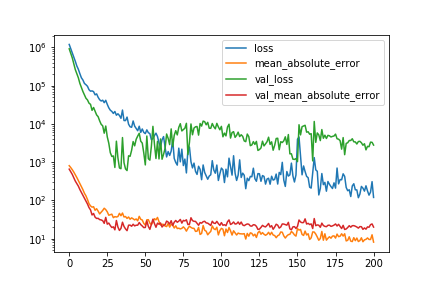

KeyboardInterrupt: 

In [348]:
models = []
output_dir = Path('loss_dense_net')
output_dir.mkdir(exist_ok=True)

# 'dense', 'resnet', 'attention'
mode = 'resnet'


def make_tf_dataset(xs_df, ys_df):
    return tf.data.Dataset.from_tensor_slices(
        make_tuple_dataset(xs_df, ys_df)
    ).shuffle(buffer_size=len(xs_df)) \
      .batch(64)

def make_tuple_dataset(xs_df, ys_df):
    if mode == 'attention':
        return (
            xs_df.to_numpy().astype(np.float32)[:, None, :], 
            ys_df.to_numpy().astype(np.float32)
        )
    else:
        return (
            xs_df.to_numpy().astype(np.float32), 
            ys_df.to_numpy().astype(np.float32)
        )
for i in trange(KFOLD):
    with tf.device('/gpu:0'):
        train_df, valid_df, test_df = get_dataset(i, no_valid=no_valid)
        train_xs_df, train_ys_df, converters = get_data(train_df, fillna='median', y_log=True)
        valid_xs_df, valid_ys_df, _ = get_data(valid_df, converters=converters)
        test_xs_df, test_ys_df, _ = get_data(test_df, converters=converters)

        #train_dataset = make_tf_dataset(train_xs_df, train_ys_df)
        #valid_dataset = make_tf_dataset(valid_xs_df, valid_ys_df)
        train_dataset = make_tuple_dataset(train_xs_df, train_ys_df)
        valid_dataset = make_tuple_dataset(valid_xs_df, valid_ys_df)
        
        if mode == 'dense':
            model = DenseRegressor([1000] * 4 + [1])
        elif mode == 'resnet':
            model = ResidualRegressor(1, n_layers=30, n_dims=1000)
        elif mode == 'attention':
            model = SelfAttentionRegression(1, n_layers=4, d_model=256)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
            loss=['mean_squared_error'], #mean_squared_logarithmic_error
            metrics=['mean_absolute_error'],
        )

        plot_callback =  PlotCallback(step=100)
        callbacks = [
            plot_callback, 
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)
        ]
        model.fit(
            *train_dataset, epochs=30000, 
            batch_size=64, 
            shuffle=True,
            validation_data=valid_dataset, 
            callbacks=callbacks,
            verbose=0
        )
        plot_callback.saveas(output_dir / f'loss_{i}.png')

        models.append(model)


In [346]:
# Evaluation models
BATCH_SIZE = 64
dl_dense_metrics = []
for key, model in enumerate(models):
    train_df, valid_df, test_df = get_dataset(i, no_valid=no_valid)
    train_xs_df, train_ys_df, _ = get_data(train_df, converters=converters, )
    valid_xs_df, valid_ys_df, _ = get_data(valid_df, converters=converters)
    test_xs_df, test_ys_df, _ = get_data(test_df, converters=converters)
    
    data = [
        ('train', train_xs_df, train_ys_df),
        ('valid', valid_xs_df, valid_ys_df),
        ('test', test_xs_df, test_ys_df),
    ]
    
    ys_conv = converters['SalePrice']
    for name, xs_df, ys_df in tqdm(data):
        xs, ys = make_tuple_dataset(xs_df, ys_df)
        
        ys_pred = []
        ys_truth = []
        for b in range(0, len(ys), BATCH_SIZE):
            start = b
            end = b + BATCH_SIZE
            ys_pred.extend(ys_conv.backward(model(xs[start:end], training=False)))
            ys_truth.extend(ys_conv.backward(ys[start:end]))
        
        errors = np.abs(np.array(ys_pred) - np.array(ys_truth)).ravel()
        dl_dense_metrics.extend([
            {
                'id': i,
                'fold': key,
                'error': error,
                'name': name,
                'truth': truth, 
                'pred': pred
            }
            for i, error, pred, truth in zip(xs_df['Id'], errors, ys_pred, ys_truth)
        ])
# dl_dense_metrics_df = pd.DataFrame(dl_dense_metrics)
dl_resnet_metrics_df = pd.DataFrame(dl_dense_metrics)

train


count      4670.000000
mean     129861.907894
std       63906.055360
min        5066.750000
25%       84747.253906
50%      118893.296875
75%      161454.558594
max      695798.187500
Name: error, dtype: float64

valid


count      1170.000000
mean     129028.789487
std       57856.698674
min          74.554688
25%       87146.568359
50%      120301.511719
75%      160683.421875
max      351518.750000
Name: error, dtype: float64

test


count      1460.000000
mean     130179.198539
std       69402.031950
min          78.750000
25%       86241.150391
50%      116523.968750
75%      160585.457031
max      813257.062500
Name: error, dtype: float64

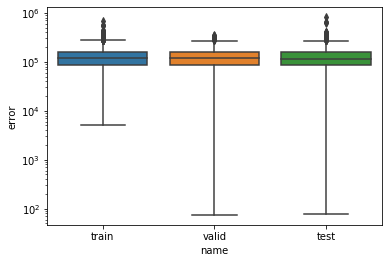

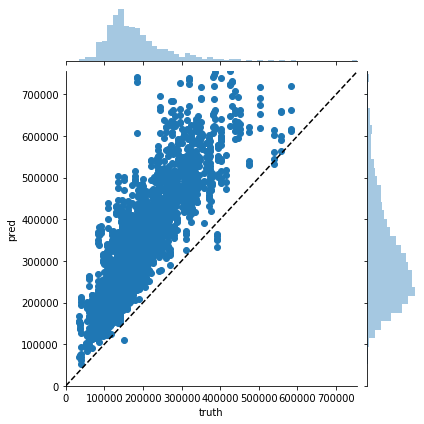

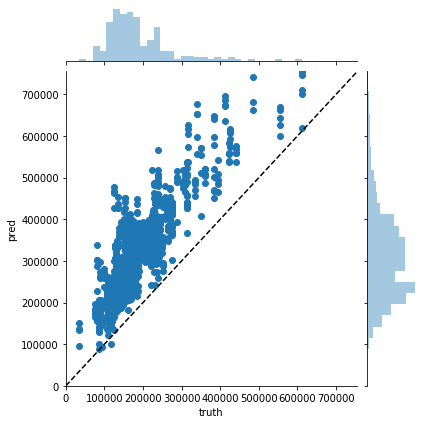

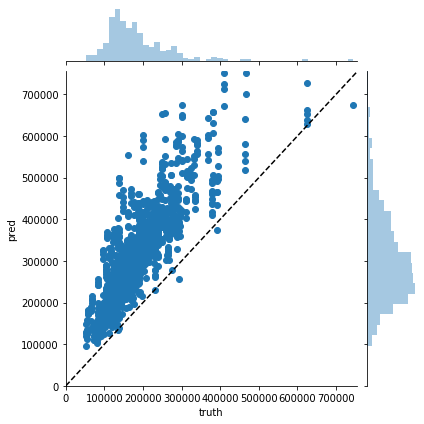

In [347]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
metric_df = dl_resnet_metrics_df
sns.boxplot(
    data=metric_df,
    x='name',
    y='error',
    ax=ax,
)
ax.set_yscale('log')

max_price = metric_df['truth'].max()
for name in ['train', 'valid', 'test']:
    df = metric_df.query(f'name=="{name}"')
    df = df.replace([np.inf, -np.inf], np.nan)

    grid = sns.jointplot(
        data=df,
        x='truth', y='pred',
        xlim=[0, max_price], ylim=[0, max_price],
        kind='scatter'
        
    )
    grid.ax_joint.plot([0,max_price], [0,max_price], color='k', linestyle='--')
    print(name)
    display(df['error'].describe())

## Dense regressor

## RUN

In [130]:
models = []
for n in range(KFOLD): 
    print(f'[{n}/{k_fold}]')
    xs_train_ = xs_train[train_index]
    xs_valid = xs_train[valid_index]
    ys_train_ = ys_train[train_index]
    ys_valid = ys_train[valid_index]

    estimator = DenseRegressor(128, 100)#, kernel_regularizer=tf.keras.regularizers.l2())
    
    estimator.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
        loss=['mean_absolute_error'], #mean_squared_logarithmic_error
        metrics=['mean_absolute_error'],
    )
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (xs_train_.astype(np.float32), ys_train_.astype(np.float32))
    ).shuffle(buffer_size=len(xs_train)) \
     .repeat(1) \
     .batch(64)
    valid_dataset = tf.data.Dataset.from_tensor_slices(
        (xs_valid.astype(np.float32), ys_valid.astype(np.float32))
    ).shuffle(buffer_size=len(xs_valid))\
     .batch(64)
    
    plot_callback = PlotCallback()
    estimator.fit(
        train_dataset, epochs=40, 
        validation_data=valid_dataset, 
        callbacks=[plot_callback, ])
    estimators.append(estimator)
    plot_callback.saveas(str(drive_path / f'loss_{n}.png'))

    ys_pred_train  = estimator.predict(tf.convert_to_tensor(xs_train_))
    ys_pred_valid  = estimator.predict(tf.convert_to_tensor(xs_valid))

    display_result(ys_train_, ys_pred_train, True, only_print=True)
    display_result(ys_valid, ys_pred_valid, only_print=True)

SyntaxError: invalid syntax (<ipython-input-130-d306c61451f1>, line 2)

In [ ]:
from collections import defaultdict
d = {}
for i, estimator in enumerate(estimators):
    d[i] = estimator.predict(tf.convert_to_tensor(test.to_numpy().astype(np.float32))).ravel()
d['id'] = test_id.to_numpy()
pd.DataFrame(d).to_csv(str(drive_path / 'output.csv'), index=False)


In [ ]:
!pip install -U pandas

In [ ]:
for i, e in enumerate(estimators):
    e.save(str(drive_path / f'estimator{i}.h5'), include_optimizer=False)
